In [26]:
import matplotlib as mpl

current_font_size = mpl.rcParams['font.size']
# mpl.rcParams['font.size'] = current_font_size * 1.5
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

1.234050878870813e-06


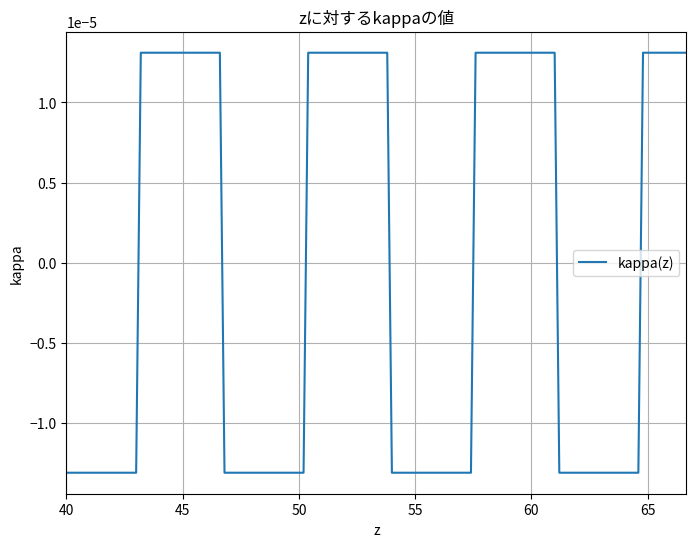

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg2
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import bisect

# ペアで幅を変える

T = 70
L = 2000
wavelength = 1.031
A0 = 1.0
B0 = 0.0
Lambda0 = 7.2

kappa_magnitude = 1.31e-05

# 事前に各領域の区間とインデックスを計算しておくリスト
# 各要素は (z_start, z_end, stripe_index) のタプル
stripe_regions = []
z_current = 0.0
stripe_index = 0

while z_current < L:
    # 各ペアの総幅 λ は、そのペアの開始位置 z_current で評価する
    current_lambda = Lambda0 / (1 + 0.0001 * z_current)
    half_period = current_lambda / 2.0

    # 正の領域: [z_current, z_current + half_period)
    stripe_regions.append((z_current, z_current + half_period, stripe_index))
    stripe_index += 1
    # 負の領域: [z_current + half_period, z_current + current_lambda)
    stripe_regions.append(
        (z_current + half_period, z_current + current_lambda, stripe_index))
    stripe_index += 1

    # 次のペアの開始位置へ更新
    z_current += current_lambda

# kappaの評価値を記録するためのリスト（必要なら）
z_kappa_vals = []


def kappa(z):
    """
    事前に用意した stripe_regions 配列から、与えられた位置 z に対応する
    区間のインデックスを取得し、偶数なら正、奇数なら負の kappa を返す関数。
    """
    for (z_start, z_end, idx) in stripe_regions:
        if z_start <= z < z_end:
            kappa_val = kappa_magnitude if idx % 2 == 0 else -kappa_magnitude
            z_kappa_vals.append((z, kappa_val))
            return kappa_val
    # 事前計算の範囲外の場合はエラーを返す（フォールバックなし）
    raise ValueError("z の値が事前計算の範囲外です。")


device = shg2.PPMgOSLT(T)

ncme = shg2.NCME(kappa, device.phase_mismatch(wavelength))
eff = ncme.solve(L, A0, B0)
print(eff)

# Plot z_kappa_vals in a separate plot
z_vals, kappa_vals = zip(*z_kappa_vals)

plt.figure(figsize=(8, 6))
plt.plot(z_vals, kappa_vals, label="kappa(z)")
plt.xlabel("z")
plt.ylabel("kappa")
plt.title("zに対するkappaの値")
plt.grid(True)
plt.xlim(L/50, L/30)
plt.legend()
plt.show()

Calculating SHG Efficiency: 100%|██████████| 1000/1000 [00:09<00:00, 100.17it/s]



最大効率: 6.964870493515378e-06
最大効率に対応する波長: 1.023162162162162 µm


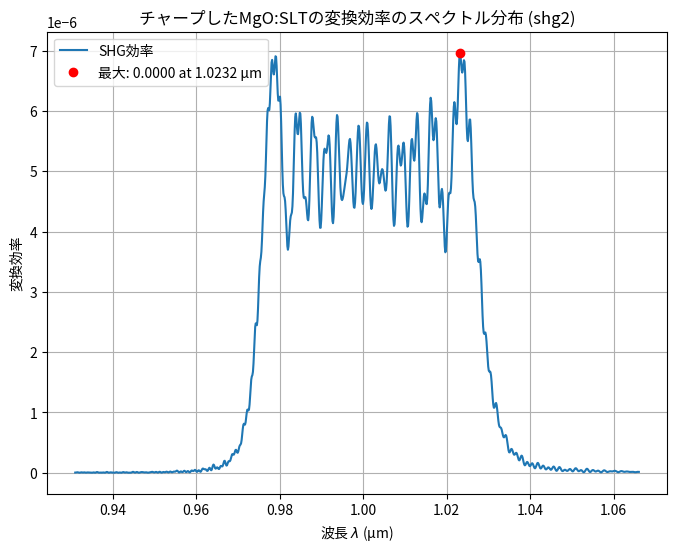

In [ ]:
import multiprocessing

lambda_min = wavelength - 0.1
lambda_max = wavelength + 0.035
lambda_values = np.linspace(lambda_min, lambda_max, 1000)

manager = multiprocessing.Manager()

device = shg2.PPMgOSLT(T)


def calc_eff(lam):
    phase_mismatch = device.phase_mismatch(lam)
    ncme = shg2.NCME(kappa, phase_mismatch)
    return ncme.solve(L, A0, B0)


with ProcessPoolExecutor() as executor:
    efficiencies = list(tqdm(
        executor.map(calc_eff, lambda_values),
        total=len(lambda_values),
        desc="Calculating SHG Efficiency"
    ))

plt.figure(figsize=(8, 6))
plt.plot(lambda_values, efficiencies, label="SHG効率")
plt.xlabel(r"波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title("チャープしたMgO:SLTの変換効率のスペクトル分布 (shg2)")
plt.grid(True)

max_efficiency = max(efficiencies)
max_index = efficiencies.index(max_efficiency)
max_lambda = lambda_values[max_index]

print(f"\n最大効率: {max_efficiency}")
print(f"最大効率に対応する波長: {max_lambda} µm")

plt.plot(max_lambda, max_efficiency, 'ro',
         label=f"最大: {max_efficiency:.4f} at {max_lambda:.4f} µm")
plt.legend()
plt.show()